In [1]:
import sys
sys.path.append('..')
import os
from itertools import chain
from collections import defaultdict
import shelve
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pymongo import MongoClient
import math

from scripts import blazmass_tools
from scripts import utils
from scripts.analysis import build_loci
from scripts.analysis import taxonomy
from scripts.analysis import DBInfo

In [2]:
# Load data
BASE = '../data'
OUT = BASE + '/tax_data'

metadata = pd.read_csv(os.path.join(BASE,"filt_metadata.csv"), index_col=0)
samp_names = list(metadata.index)

In [3]:
sample_pairs = metadata.reset_index().set_index(['enriched', 'technical']).sort_index().groupby(level=[0,1])

pairs = []
for x, y in sample_pairs:
    pairs.append(list(y['index'].values))

n14_samps = [x[0] for x in pairs]
n15_samps = [x[1] for x in pairs]

n14_un_samps = [x for x in n14_samps if x.startswith('UL_')]
n15_un_samps = [x for x in n15_samps if x.startswith('UL_')]

n14_enr_samps = [x for x in n14_samps if x.startswith('CL_')]
n15_enr_samps = [x for x in n15_samps if x.startswith('CL_')]

In [4]:
all_dfs = defaultdict(dict)

for rank in ['family', 'phylum']:
    all_dfs[rank] = pd.read_csv(os.path.join(OUT,"{}_count.csv".format(rank)), index_col=0)

In [5]:
all_dfs['phylum'].head()

,count,organism_name,taxid,sample
7711,1690.711194,chordata,7711,CL_Mix_Pool_N_5
1117,865.068930,cyanobacteria,1117,CL_Mix_Pool_N_5
1239,316.220212,firmicutes,1239,CL_Mix_Pool_N_5
976,248.654522,bacteroidetes,976,CL_Mix_Pool_N_5
74201,167.588248,verrucomicrobia,74201,CL_Mix_Pool_N_5


In [7]:
def plot_tax(rank, samples):
    from matplotlib.ticker import FuncFormatter
    from itertools import cycle
    import matplotlib
    
    def to_percent(y, position):
        s = str(100 * y)
        if matplotlib.rcParams['text.usetex'] is True:
            return s + r'$\%$'
        else:
            return s + '%'
    
    sns.set_style('whitegrid')
    
    all_df = all_dfs[rank]
    #f = plt.figure(figsize=(12*1.25,8*1.25))
    f = plt.figure()
    df_pivot = all_df.pivot_table(values="count", index="sample", columns="organism_name").dropna(1, thresh=3)
    order = ['other'] + list(df_pivot.sum().sort_values().index)
    df_pivot = df_pivot.loc[samples]
    
    bad_fams = ['muridae', 'poaceae', 'hominidae', 'phormidiaceae']
    bad_phyla = ['chordata', 'cyanobacteria']
    
    if rank == "family":
        for bad_fam in bad_fams:
            if bad_fam in df_pivot:
                del df_pivot[bad_fam]
    elif rank == "phylum":
        for bad_phylum in bad_phyla:
            if bad_phylum in df_pivot:
                del df_pivot[bad_phylum]
    df_pivot.to_csv(os.path.join(OUT,"{}_count_pivot.csv".format(rank)))
    
    df_pivot = df_pivot.div(df_pivot.sum(axis=1), axis=0)
    df_pivot = df_pivot[df_pivot.columns[df_pivot.sum()>0.02]]
    df_pivot = df_pivot[[o for o in order if o in df_pivot]]
    other = pd.Series(1-df_pivot.sum(axis=1), name = "Other")
    df_pivot['other'] = other
    df_pivot = df_pivot[[-1]+list(range(len(df_pivot.columns)-1))]
    df_pivot.index = [metadata.loc[x, 'category']+' '+str(metadata.loc[x, 'technical']) for x in df_pivot.index]
    df_pivot = df_pivot.sort_index()

    # Filter out missing famalies for consistant coloring
    colors = sns.color_palette("cubehelix", 8)
    order = [o for o in order if not o in bad_fams+bad_phyla]
    c_dict = dict(zip(order[::-1], cycle(colors[::-1])))
    
    ax = df_pivot.plot.bar(stacked=True, legend = 'reverse', ylim=(0,1), ax=f.gca(),  color=map(c_dict.get,df_pivot.columns))
    lgd = plt.legend()
    handles, labels = ax.get_legend_handles_labels()
    lgd = plt.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax.set_ylabel("Normalized Count")
    ax.title.set_fontsize(20)
    formatter = FuncFormatter(to_percent)
    plt.gca().yaxis.set_major_formatter(formatter)
    f.subplots_adjust(right=0.8)

/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


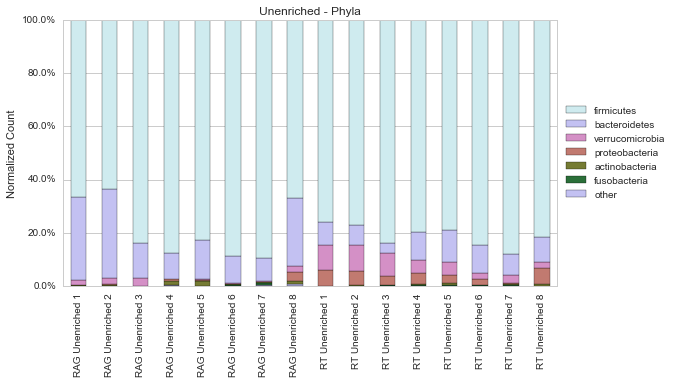

In [8]:
plot_tax("phylum", n14_un_samps + n15_un_samps)
plt.title('Unenriched - Phyla')
#plt.savefig(os.path.join(OUT,"Unenr_phlya.pdf"), bbox_inches='tight');

/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


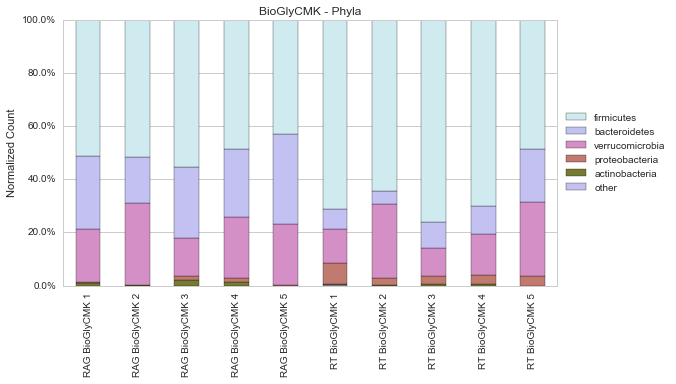

In [9]:
plot_tax("phylum", n14_enr_samps + n15_enr_samps)
plt.title('BioGlyCMK - Phyla')
#plt.savefig(os.path.join(OUT,"BioGlyCMK_phlya.pdf"), bbox_inches='tight');

Enrichment seems to filter out some firmicutes, and leave you with more verrucomicrobia

/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


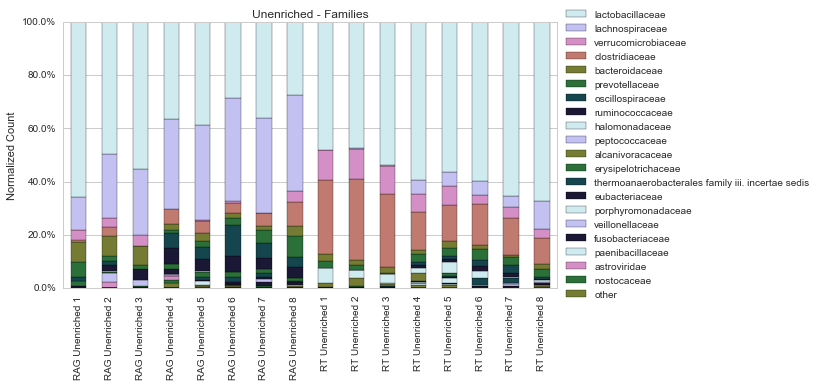

In [10]:
plot_tax("family", n14_un_samps+n15_un_samps)
plt.title('Unenriched - Families')
#plt.savefig(os.path.join(OUT,"Unenr_fams.pdf"), bbox_inches='tight');

Big Changes:  
RT : Decrease in lachnospiracae.   Increase in clostridiaceae, verrucomicrobiaceae  

Subtle changes:  
RAG: More bacteroidaceae, more oscillospiraceae, more ruminococcaceae  
RT: More Halomondaceae

/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


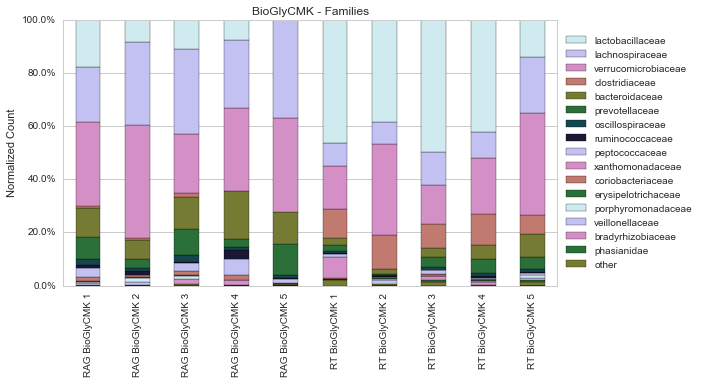

In [11]:
plot_tax("family", n14_enr_samps+n15_enr_samps)
plt.title('BioGlyCMK - Families')
#plt.savefig(os.path.join(OUT,"BioGlyCMK_fams.pdf"), bbox_inches='tight');

Big Changess: RT: more lactobacillaceae, more clostridaceae, less lachnospiraceae, less bacterodiaceae 

/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


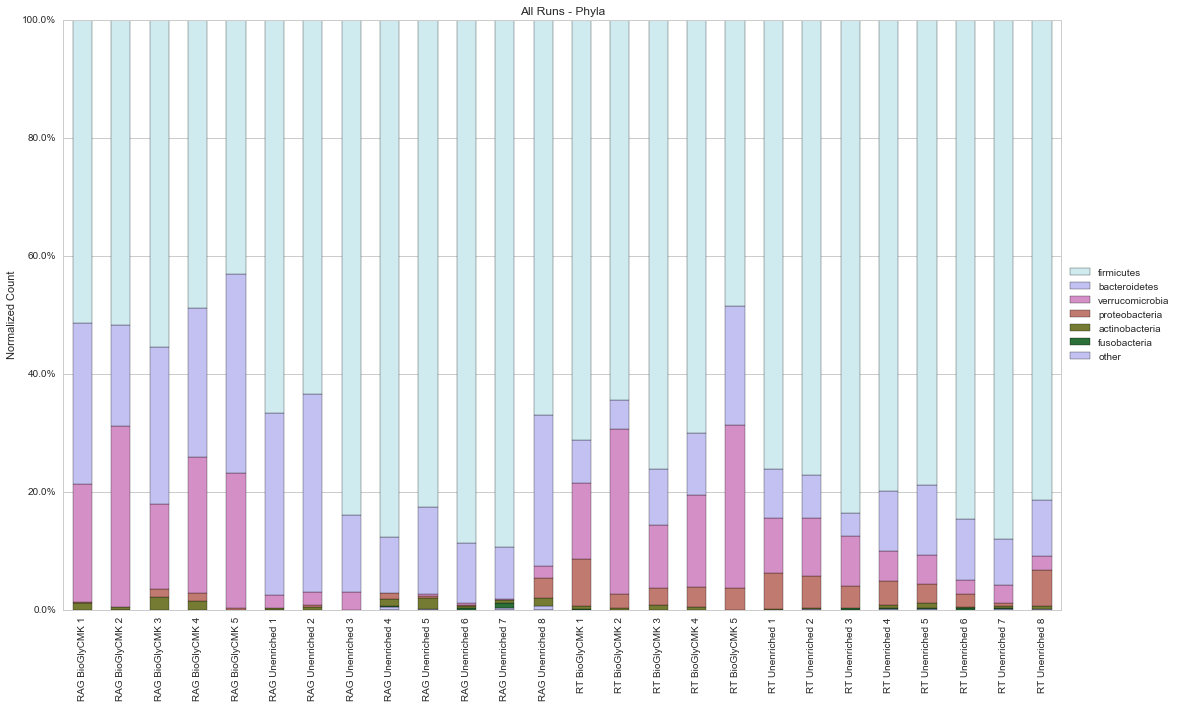

In [12]:
plot_tax('phylum', samp_names)
plt.title('All Runs - Phyla')
#plt.savefig(os.path.join(OUT,"All_phlya.pdf"), bbox_inches='tight');

/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


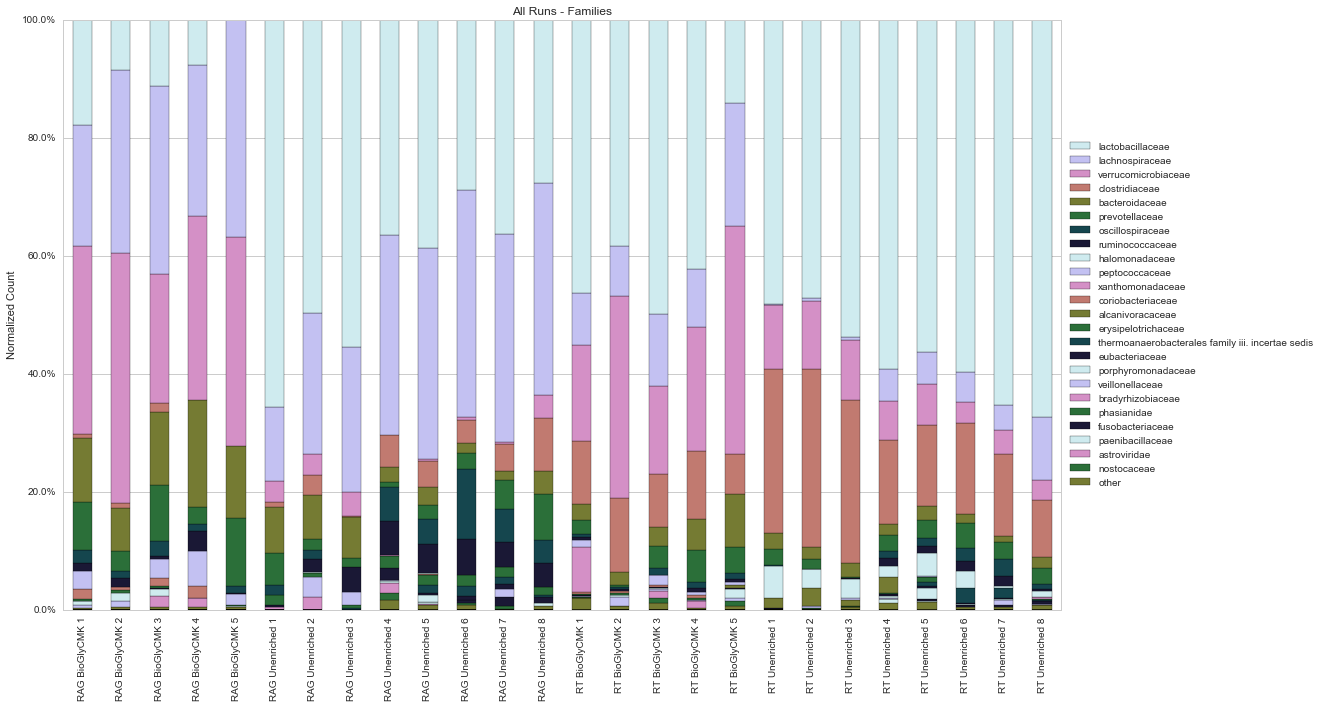

In [13]:
plot_tax('family', samp_names)
plt.title('All Runs - Families')
#plt.savefig(os.path.join(OUT,"all_fams.pdf"), bbox_inches='tight');

Enriched vs unenriched changes:  
Enriched has far more verrucomicrobiaceae and far fewer lactobacillaceae  

Enriched also seems to pick up more bacteroidaceae (especially in RAG)